# Method 3 - Best Ideas Medium Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[(best_ideas['herf_pct'] > (1 / 3)) & (best_ideas['herf_pct'] < (2 / 3))]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

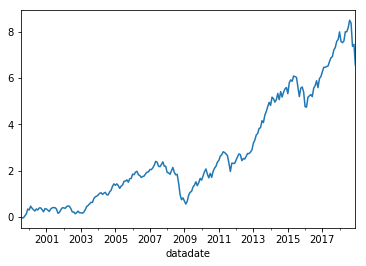

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.347285
2000-12-31    0.013719
2001-12-31    0.023972
2002-12-31   -0.149828
2003-12-31    0.599894
2004-12-31    0.278790
2005-12-31    0.098292
2006-12-31    0.103717
2007-12-31    0.083754
2008-12-31   -0.427097
2009-12-31    0.458989
2010-12-31    0.263442
2011-12-31   -0.015696
2012-12-31    0.174006
2013-12-31    0.527126
2014-12-31    0.107837
2015-12-31   -0.029519
2016-12-31    0.103468
2017-12-31    0.226671
2018-12-31   -0.128217
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     539.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.66e-115
Time:                        12:51:34   Log-Likelihood:                 632.43
No. Observations:                 234   AIC:                            -1255.
Df Residuals:                     229   BIC:                            -1238.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.283      0.001       0.001       0.006
mktrf          1.0131      0.031     33.134      0.000       0.953       1.073
me             0.5093      0.036     14.320      0.000       0.439       0.579
ia             0.0545      0.054      1.008      0.314      -0.052       0.161
roe            0.0681      0.046      1.471      0.143      -0.023       0.159
==============================================================================
Omnibus:                       43.050   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.204
Skew:                           0.588   Prob(JB):                     1.67e-45
Kurtosis:                       7.446   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     658.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.67e-124
Time:                        12:51:34   Log-Likelihood:                 632.43
No. Observations:                 234   AIC:                            -1255.
Df Residuals:                     229   BIC:                            -1238.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.270      0.001       0.001       0.006
mktrf          1.0131      0.036     28.003      0.000       0.942       1.084
me             0.5093      0.039     12.976      0.000       0.432       0.586
ia             0.0545      0.132      0.413      0.680      -0.204       0.313
roe            0.0681      0.061      1.120      0.263      -0.051       0.187
==============================================================================
Omnibus:                       43.050   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.204
Skew:                           0.588   Prob(JB):                     1.67e-45
Kurtosis:                       7.446   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.902
Method:                 Least Squares   F-statistic:                     1152.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.37e-150
Time:                        12:51:34   Log-Likelihood:                 632.43
No. Observations:                 234   AIC:                            -1255.
Df Residuals:                     229   BIC:                            -1238.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0037      0.001      3.504      0.000       0.002       0.006
mktrf          1.0131      0.031     32.531      0.000       0.952       1.074
me             0.5093      0.038     13.509      0.000       0.435       0.583
ia             0.0545      0.129      0.424      0.672      -0.198       0.307
roe            0.0681      0.050      1.374      0.170      -0.029       0.165
==============================================================================
Omnibus:                       43.050   Durbin-Watson:                   2.008
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              206.204
Skew:                           0.588   Prob(JB):                     1.67e-45
Kurtosis:                       7.446   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     375.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.68e-108
Time:                        12:51:34   Log-Likelihood:                 618.08
No. Observations:                 234   AIC:                            -1224.
Df Residuals:                     228   BIC:                            -1203.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      3.132      0.002       0.001       0.006
mktrf          1.0087      0.033     30.898      0.000       0.944       1.073
smb            0.5170      0.043     12.002      0.000       0.432       0.602
hml           -0.0198      0.051     -0.390      0.697      -0.120       0.080
rmw            0.0252      0.057      0.439      0.661      -0.088       0.138
cma            0.1300      0.073      1.781      0.076      -0.014       0.274
==============================================================================
Omnibus:                       40.296   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.020
Skew:                           0.540   Prob(JB):                     9.01e-42
Kurtosis:                       7.268   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     488.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.23e-119
Time:                        12:51:34   Log-Likelihood:                 618.08
No. Observations:                 234   AIC:                            -1224.
Df Residuals:                     228   BIC:                            -1203.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      2.708      0.007       0.001       0.007
mktrf          1.0087      0.039     25.970      0.000       0.933       1.085
smb            0.5170      0.039     13.329      0.000       0.441       0.593
hml           -0.0198      0.069     -0.288      0.774      -0.155       0.115
rmw            0.0252      0.063      0.402      0.688      -0.098       0.148
cma            0.1300      0.147      0.886      0.375      -0.157       0.417
==============================================================================
Omnibus:                       40.296   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.020
Skew:                           0.540   Prob(JB):                     9.01e-42
Kurtosis:                       7.268   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.889
Method:                 Least Squares   F-statistic:                     778.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.61e-141
Time:                        12:51:34   Log-Likelihood:                 618.08
No. Observations:                 234   AIC:                            -1224.
Df Residuals:                     228   BIC:                            -1203.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0038      0.001      2.698      0.007       0.001       0.007
mktrf          1.0087      0.035     28.733      0.000       0.940       1.078
smb            0.5170      0.038     13.505      0.000       0.442       0.592
hml           -0.0198      0.073     -0.271      0.786      -0.163       0.123
rmw            0.0252      0.064      0.393      0.694      -0.101       0.151
cma            0.1300      0.153      0.850      0.395      -0.170       0.430
==============================================================================
Omnibus:                       40.296   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              189.020
Skew:                           0.540   Prob(JB):                     9.01e-42
Kurtosis:                       7.268   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     504.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.94e-112
Time:                        12:51:34   Log-Likelihood:                 625.27
No. Observations:                 234   AIC:                            -1241.
Df Residuals:                     229   BIC:                            -1223.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      3.097      0.002       0.001       0.006
mktrf          1.0572      0.029     36.423      0.000       1.000       1.114
smb            0.4348      0.036     12.000      0.000       0.363       0.506
hml            0.1704      0.036      4.735      0.000       0.099       0.241
umd            0.1316      0.024      5.573      0.000       0.085       0.178
==============================================================================
Omnibus:                       29.835   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.166
Skew:                           0.541   Prob(JB):                     6.45e-18
Kurtosis:                       5.636   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     359.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.73e-97
Time:                        12:51:34   Log-Likelihood:                 625.27
No. Observations:                 234   AIC:                            -1241.
Df Residuals:                     229   BIC:                            -1223.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.800      0.005       0.001       0.006
mktrf          1.0572      0.044     24.156      0.000       0.971       1.143
smb            0.4348      0.040     10.947      0.000       0.357       0.513
hml            0.1704      0.088      1.942      0.052      -0.002       0.342
umd            0.1316      0.054      2.440      0.015       0.026       0.237
==============================================================================
Omnibus:                       29.835   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.166
Skew:                           0.541   Prob(JB):                     6.45e-18
Kurtosis:                       5.636   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     520.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.17e-113
Time:                        12:51:34   Log-Likelihood:                 625.27
No. Observations:                 234   AIC:                            -1241.
Df Residuals:                     229   BIC:                            -1223.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.001      2.774      0.006       0.001       0.006
mktrf          1.0572      0.034     31.248      0.000       0.991       1.124
smb            0.4348      0.036     12.017      0.000       0.364       0.506
hml            0.1704      0.090      1.884      0.060      -0.007       0.348
umd            0.1316      0.047      2.790      0.005       0.039       0.224
==============================================================================
Omnibus:                       29.835   Durbin-Watson:                   1.809
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.166
Skew:                           0.541   Prob(JB):                     6.45e-18
Kurtosis:                       5.636   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     223.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.40e-53
Time:                        12:51:34   Log-Likelihood:                 300.05
No. Observations:                 120   AIC:                            -590.1
Df Residuals:                     115   BIC:                            -576.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      2.682      0.008       0.001       0.009
mktrf          1.0688      0.052     20.446      0.000       0.965       1.172
me             0.5216      0.052     10.102      0.000       0.419       0.624
ia             0.1046      0.081      1.294      0.198      -0.056       0.265
roe            0.1404      0.072      1.962      0.052      -0.001       0.282
==============================================================================
Omnibus:                       15.242   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.659
Skew:                           0.386   Prob(JB):                     4.03e-09
Kurtosis:                       5.671   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     334.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.52e-62
Time:                        12:51:34   Log-Likelihood:                 300.05
No. Observations:                 120   AIC:                            -590.1
Df Residuals:                     115   BIC:                            -576.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      2.884      0.004       0.002       0.009
mktrf          1.0688      0.061     17.467      0.000       0.949       1.189
me             0.5216      0.046     11.335      0.000       0.431       0.612
ia             0.1046      0.159      0.658      0.511      -0.207       0.416
roe            0.1404      0.074      1.908      0.056      -0.004       0.285
==============================================================================
Omnibus:                       15.242   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.659
Skew:                           0.386   Prob(JB):                     4.03e-09
Kurtosis:                       5.671   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.882
Method:                 Least Squares   F-statistic:                     535.3
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.61e-73
Time:                        12:51:34   Log-Likelihood:                 300.05
No. Observations:                 120   AIC:                            -590.1
Df Residuals:                     115   BIC:                            -576.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0052      0.002      3.346      0.001       0.002       0.008
mktrf          1.0688      0.043     24.928      0.000       0.985       1.153
me             0.5216      0.045     11.485      0.000       0.433       0.611
ia             0.1046      0.151      0.693      0.488      -0.191       0.400
roe            0.1404      0.043      3.238      0.001       0.055       0.225
==============================================================================
Omnibus:                       15.242   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.659
Skew:                           0.386   Prob(JB):                     4.03e-09
Kurtosis:                       5.671   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     149.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.21e-48
Time:                        12:51:34   Log-Likelihood:                 291.27
No. Observations:                 120   AIC:                            -570.5
Df Residuals:                     114   BIC:                            -553.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      2.822      0.006       0.002       0.010
mktrf          1.0618      0.060     17.825      0.000       0.944       1.180
smb            0.5328      0.067      7.898      0.000       0.399       0.666
hml           -0.0520      0.083     -0.629      0.531      -0.216       0.112
rmw            0.0790      0.097      0.810      0.420      -0.114       0.272
cma            0.2192      0.107      2.052      0.042       0.008       0.431
==============================================================================
Omnibus:                       11.526   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               25.005
Skew:                           0.285   Prob(JB):                     3.72e-06
Kurtosis:                       5.162   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     376.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.44e-69
Time:                        12:51:34   Log-Likelihood:                 291.27
No. Observations:                 120   AIC:                            -570.5
Df Residuals:                     114   BIC:                            -553.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      2.707      0.007       0.002       0.010
mktrf          1.0618      0.073     14.632      0.000       0.920       1.204
smb            0.5328      0.055      9.772      0.000       0.426       0.640
hml           -0.0520      0.115     -0.451      0.652      -0.278       0.174
rmw            0.0790      0.112      0.702      0.483      -0.141       0.299
cma            0.2192      0.182      1.202      0.229      -0.138       0.577
==============================================================================
Omnibus:                       11.526   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               25.005
Skew:                           0.285   Prob(JB):                     3.72e-06
Kurtosis:                       5.162   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     626.1
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.06e-81
Time:                        12:51:34   Log-Likelihood:                 291.27
No. Observations:                 120   AIC:                            -570.5
Df Residuals:                     114   BIC:                            -553.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0061      0.002      2.881      0.004       0.002       0.010
mktrf          1.0618      0.064     16.543      0.000       0.936       1.188
smb            0.5328      0.057      9.418      0.000       0.422       0.644
hml           -0.0520      0.125     -0.414      0.679      -0.298       0.194
rmw            0.0790      0.125      0.633      0.527      -0.166       0.323
cma            0.2192      0.188      1.163      0.245      -0.150       0.588
==============================================================================
Omnibus:                       11.526   Durbin-Watson:                   2.174
Prob(Omnibus):                  0.003   Jarque-Bera (JB):               25.005
Skew:                           0.285   Prob(JB):                     3.72e-06
Kurtosis:                       5.162   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     209.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.56e-52
Time:                        12:51:34   Log-Likelihood:                 296.67
No. Observations:                 120   AIC:                            -583.3
Df Residuals:                     115   BIC:                            -569.4
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.002      3.408      0.001       0.003       0.011
mktrf          1.1105      0.047     23.444      0.000       1.017       1.204
smb            0.4103      0.054      7.608      0.000       0.303       0.517
hml            0.2030      0.054      3.759      0.000       0.096       0.310
umd            0.1571      0.033      4.717      0.000       0.091       0.223
==============================================================================
Omnibus:                        5.633   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                7.622
Skew:                           0.178   Prob(JB):                       0.0221
Kurtosis:                       4.183   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     205.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.90e-51
Time:                        12:51:34   Log-Likelihood:                 296.67
No. Observations:                 120   AIC:                            -583.3
Df Residuals:                     115   BIC:                            -569.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.002      3.683      0.000       0.003       0.010
mktrf          1.1105      0.070     15.950      0.000       0.974       1.247
smb            0.4103      0.054      7.617      0.000       0.305       0.516
hml            0.2030      0.104      1.951      0.051      -0.001       0.407
umd            0.1571      0.063      2.501      0.012       0.034       0.280
==============================================================================
Omnibus:                        5.633   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                7.622
Skew:                           0.178   Prob(JB):                       0.0221
Kurtosis:                       4.183   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.879
Model:                            OLS   Adj. R-squared:                  0.875
Method:                 Least Squares   F-statistic:                     351.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.88e-63
Time:                        12:51:34   Log-Likelihood:                 296.67
No. Observations:                 120   AIC:                            -583.3
Df Residuals:                     115   BIC:                            -569.4
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0067      0.002      4.240      0.000       0.004       0.010
mktrf          1.1105      0.046     24.403      0.000       1.021       1.200
smb            0.4103      0.043      9.469      0.000       0.325       0.495
hml            0.2030      0.106      1.922      0.055      -0.004       0.410
umd            0.1571      0.047      3.331      0.001       0.065       0.250
==============================================================================
Omnibus:                        5.633   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.060   Jarque-Bera (JB):                7.622
Skew:                           0.178   Prob(JB):                       0.0221
Kurtosis:                       4.183   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     586.2
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.04e-72
Time:                        12:51:34   Log-Likelihood:                 370.31
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     109   BIC:                            -716.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      2.372      0.019       0.000       0.004
mktrf          0.9917      0.028     35.097      0.000       0.936       1.048
me             0.4517      0.044     10.355      0.000       0.365       0.538
ia            -0.1434      0.061     -2.370      0.020      -0.263      -0.024
roe           -0.1458      0.053     -2.742      0.007      -0.251      -0.040
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.125
Skew:                          -0.014   Prob(JB):                        0.939
Kurtosis:                       3.160   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     702.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.13e-77
Time:                        12:51:34   Log-Likelihood:                 370.31
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     109   BIC:                            -716.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.871      0.061      -0.000       0.005
mktrf          0.9917      0.024     40.800      0.000       0.944       1.039
me             0.4517      0.040     11.212      0.000       0.373       0.531
ia            -0.1434      0.058     -2.475      0.013      -0.257      -0.030
roe           -0.1458      0.053     -2.758      0.006      -0.249      -0.042
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.125
Skew:                          -0.014   Prob(JB):                        0.939
Kurtosis:                       3.160   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.956
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     1111.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.54e-87
Time:                        12:51:34   Log-Likelihood:                 370.31
No. Observations:                 114   AIC:                            -730.6
Df Residuals:                     109   BIC:                            -716.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0023      0.001      1.764      0.078      -0.000       0.005
mktrf          0.9917      0.026     38.037      0.000       0.941       1.043
me             0.4517      0.043     10.546      0.000       0.368       0.536
ia            -0.1434      0.064     -2.233      0.026      -0.269      -0.018
roe           -0.1458      0.042     -3.433      0.001      -0.229      -0.063
==============================================================================
Omnibus:                        0.433   Durbin-Watson:                   1.750
Prob(Omnibus):                  0.805   Jarque-Bera (JB):                0.125
Skew:                          -0.014   Prob(JB):                        0.939
Kurtosis:                       3.160   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     479.5
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.34e-72
Time:                        12:51:34   Log-Likelihood:                 372.02
No. Observations:                 114   AIC:                            -732.0
Df Residuals:                     108   BIC:                            -715.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      1.313      0.192      -0.001       0.003
mktrf          1.0068      0.027     37.753      0.000       0.954       1.060
smb            0.4378      0.043     10.111      0.000       0.352       0.524
hml           -0.0359      0.055     -0.650      0.517      -0.145       0.074
rmw           -0.1970      0.068     -2.913      0.004      -0.331      -0.063
cma           -0.0871      0.086     -1.015      0.313      -0.257       0.083
==============================================================================
Omnibus:                        0.849   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.654   Jarque-Bera (JB):                0.454
Skew:                          -0.110   Prob(JB):                        0.797
Kurtosis:                       3.217   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     422.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           3.43e-69
Time:                        12:51:34   Log-Likelihood:                 372.02
No. Observations:                 114   AIC:                            -732.0
Df Residuals:                     108   BIC:                            -715.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.977      0.329      -0.001       0.004
mktrf          1.0068      0.024     42.733      0.000       0.961       1.053
smb            0.4378      0.040     11.001      0.000       0.360       0.516
hml           -0.0359      0.051     -0.708      0.479      -0.135       0.063
rmw           -0.1970      0.065     -3.013      0.003      -0.325      -0.069
cma           -0.0871      0.068     -1.279      0.201      -0.221       0.046
==============================================================================
Omnibus:                        0.849   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.654   Jarque-Bera (JB):                0.454
Skew:                          -0.110   Prob(JB):                        0.797
Kurtosis:                       3.217   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.957
Model:                            OLS   Adj. R-squared:                  0.955
Method:                 Least Squares   F-statistic:                     601.8
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           4.09e-77
Time:                        12:51:34   Log-Likelihood:                 372.02
No. Observations:                 114   AIC:                            -732.0
Df Residuals:                     108   BIC:                            -715.6
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.001      0.924      0.356      -0.001       0.004
mktrf          1.0068      0.023     42.881      0.000       0.961       1.053
smb            0.4378      0.040     10.816      0.000       0.358       0.517
hml           -0.0359      0.057     -0.628      0.530      -0.148       0.076
rmw           -0.1970      0.062     -3.196      0.001      -0.318      -0.076
cma           -0.0871      0.064     -1.352      0.176      -0.213       0.039
==============================================================================
Omnibus:                        0.849   Durbin-Watson:                   1.760
Prob(Omnibus):                  0.654   Jarque-Bera (JB):                0.454
Skew:                          -0.110   Prob(JB):                        0.797
Kurtosis:                       3.217   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     552.6
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.25e-71
Time:                        12:51:35   Log-Likelihood:                 367.10
No. Observations:                 114   AIC:                            -724.2
Df Residuals:                     109   BIC:                            -710.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.523      0.602      -0.001       0.002
mktrf          1.0322      0.028     37.476      0.000       0.978       1.087
smb            0.4772      0.043     11.112      0.000       0.392       0.562
hml            0.0165      0.044      0.372      0.711      -0.071       0.104
umd            0.0421      0.033      1.262      0.210      -0.024       0.108
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.589
Skew:                          -0.139   Prob(JB):                        0.745
Kurtosis:                       2.784   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     386.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.02e-63
Time:                        12:51:35   Log-Likelihood:                 367.10
No. Observations:                 114   AIC:                            -724.2
Df Residuals:                     109   BIC:                            -710.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.385      0.700      -0.002       0.003
mktrf          1.0322      0.027     37.545      0.000       0.978       1.086
smb            0.4772      0.035     13.477      0.000       0.408       0.547
hml            0.0165      0.060      0.276      0.782      -0.100       0.133
umd            0.0421      0.029      1.461      0.144      -0.014       0.099
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.589
Skew:                          -0.139   Prob(JB):                        0.745
Kurtosis:                       2.784   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.953
Model:                            OLS   Adj. R-squared:                  0.951
Method:                 Least Squares   F-statistic:                     562.7
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.78e-72
Time:                        12:51:35   Log-Likelihood:                 367.10
No. Observations:                 114   AIC:                            -724.2
Df Residuals:                     109   BIC:                            -710.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.001      0.374      0.708      -0.002       0.003
mktrf          1.0322      0.025     40.486      0.000       0.982       1.082
smb            0.4772      0.031     15.241      0.000       0.416       0.539
hml            0.0165      0.065      0.251      0.801      -0.112       0.145
umd            0.0421      0.029      1.446      0.148      -0.015       0.099
==============================================================================
Omnibus:                        0.471   Durbin-Watson:                   1.593
Prob(Omnibus):                  0.790   Jarque-Bera (JB):                0.589
Skew:                          -0.139   Prob(JB):                        0.745
Kurtosis:                       2.784   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""